<a href="https://colab.research.google.com/github/zsx711/AIPI-590/blob/main/notebook/AIPI_590_Assignment06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #06


This assignment performs an analysis on the California Housing dataset using a Random Forest model. It starts with exploratory data analysis to check correlations between features, followed by model training on scaled data. The script generates Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) plots for the 'MedInc' feature to show its influence on the model's predictions. Additionally, Accumulated Local Effects (ALE) plots are generated to provide insights into the feature's local effects while accounting for interactions with other features. For the assignment, I used ChatGPT and class material [global_explanations.ipynb](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/global_explanations.ipynb) as guidance.

Shunxin Zhang

Notebook:https://colab.research.google.com/github/zsx711/AIPI-590/blob/main/notebook/AIPI_590_Assignment06.ipynb [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zsx711/AIPI-590/blob/main/notebook/AIPI_590_Assignment06.ipynb)

In [18]:
# Install necessary libraries
!pip install pandas matplotlib seaborn scikit-learn alibi
!pip install pdpbox==0.2.1

  Using cached PDPbox-0.2.1.tar.gz (34.0 MB)
  Preparing metadata (setup.py) ... done
  Using cached matplotlib-3.1.1.tar.gz (37.8 MB)
  Preparing metadata (setup.py) ... done
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [19]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
from pdpbox import pdp, info_plots
from alibi.explainers import ALE

In [20]:
# Check if the repository already exists, and remove it if so
repo_name = "AIPI-590"
if os.path.exists(repo_name):
    !rm -rf {repo_name}  # Remove the existing directory

# Clone GitHub repository (AIPI-590)
repo_name = "AIPI-590"
git_path = 'https://github.com/zsx711/AIPI-590.git'
!git clone "{git_path}"

# Change the working directory to 'notebook' inside your repo
notebook_dir = 'notebook'
path_to_notebook = os.path.join(repo_name, notebook_dir)
%cd "{path_to_notebook}"

Cloning into 'AIPI-590'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 112 (delta 32), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (112/112), 2.86 MiB | 8.53 MiB/s, done.
Resolving deltas: 100% (32/32), done.
/content/AIPI-590/notebook


             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude        target  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.54000

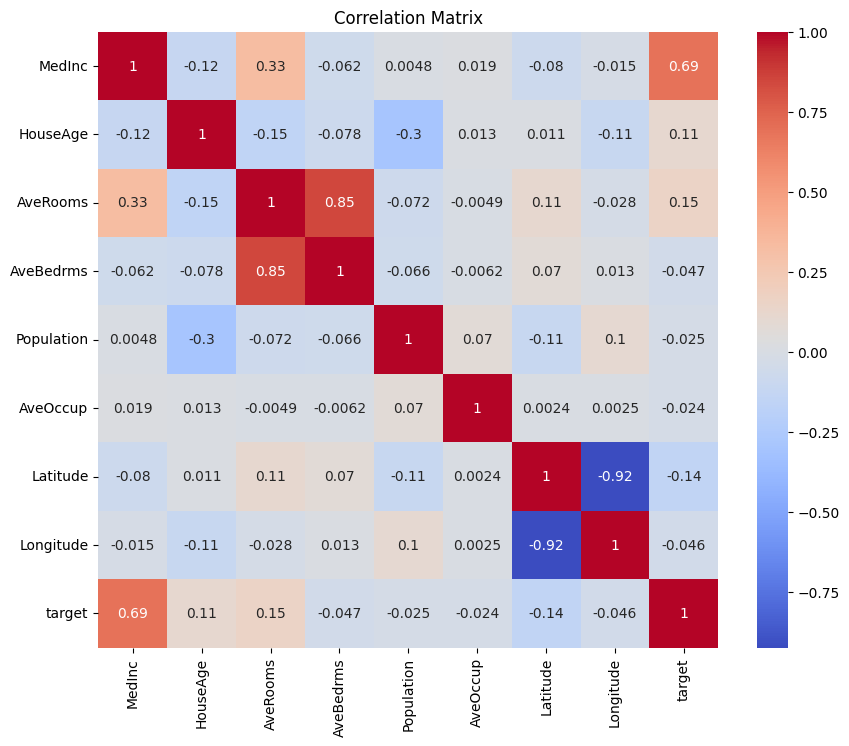

In [21]:
# Load dataset
cal_housing = fetch_california_housing()
df = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
df['target'] = cal_housing.target

# Perform basic exploratory analysis
print(df.describe())

# Visualize correlations between features
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [22]:
# Split the data
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a RandomForest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

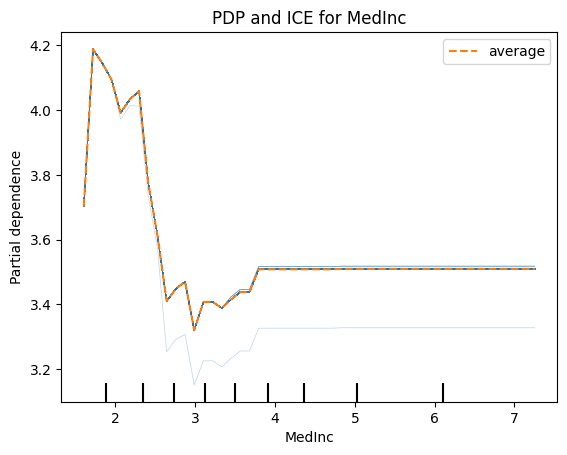

In [23]:
from sklearn.inspection import PartialDependenceDisplay

# PDP and ICE plot for 'MedInc'
features = ['MedInc']  # Feature you want to plot

# Use unscaled data for plotting, but keep the model predictions on scaled data
PartialDependenceDisplay.from_estimator(
    model,
    X_test,  # Use unscaled data here to match feature names
    features,
    kind='both',  # Show both ICE and PDP
    grid_resolution=50
)
plt.title('PDP and ICE for MedInc')
plt.show()

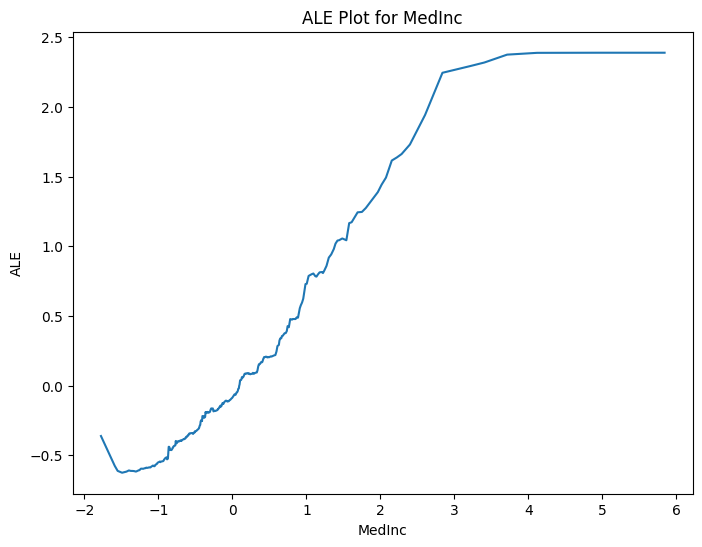

In [24]:
# Generate ALE explanation
ale = ALE(model.predict, feature_names=X.columns)
explanation = ale.explain(X_test_scaled)  # Scaled data is fine for ALE

# Manually plot ALE results for 'MedInc'
# Find the index of the feature 'MedInc' in the feature_names list
feature_idx = X.columns.get_loc('MedInc')

# Extract the ALE values for 'MedInc'
ale_values = explanation.ale_values[feature_idx]
ale_feature_values = explanation.feature_values[feature_idx]

# Plot ALE for 'MedInc'
plt.figure(figsize=(8, 6))
plt.plot(ale_feature_values, ale_values)
plt.xlabel('MedInc')
plt.ylabel('ALE')
plt.title('ALE Plot for MedInc')
plt.show()

# Explaination and Findings
The Partial Dependence Plot (PDP) and Individual Conditional Expectation (ICE) plots for the 'MedInc' (median income) feature show a clear positive relationship between income and house prices — higher incomes generally lead to higher home values. The PDP provides the average effect of income across all data points, while the ICE plot shows how individual cases can differ, revealing that the impact of income varies from one house to another. The Accumulated Local Effects (ALE) plot also shows a positive relationship, but unlike the PDP, it adjusts for correlations between features, offering a more precise view of income's influence. Interestingly, the ALE plot differs slightly from the PDP because it takes into account interactions with other features, like 'AveRooms' (average rooms), which are moderately correlated with 'MedInc'. This means the PDP might exaggerate income's effect since it doesn't correct for these interactions, whereas ALE provides a more reliable estimate by factoring them in. In my earlier exploratory analysis, I noticed these correlations, and understanding the relationship between features helped me gain more accurate insights into the model’s behavior.